### Set up environment

In [1]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [2]:
import os
import shutil
import tempfile
import h5py

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm


### Setup a data directory and download dataset


In [3]:
directory = os.environ.get("rat_spkcnt_data")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/rd/3ld2jywx6cs16b36034rvhhc0000gn/T/tmpno_8zs6k


## Prepare validation set data loader

In [5]:
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SpkCountDataset(Dataset):
    def __init__(self, spkcount_file, transform=None):
        # Load SpkCount data from HDF5 files using h5py 
        with h5py.File(spkcount_file, 'r') as spkcount_file_h5:
            spkcount_data = spkcount_file_h5['SpkCnt'][:]
        
        f = np.where(spkcount_data != 0)[0]
        time_bin = 312 * 60 * 1

        # Create a list of dictionaries, each containing the relevant data
        self.data = [{"spkcount": spkcount_data[f_i - time_bin:f_i + time_bin, :]} for f_i in f]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the spike count data from the dataset
        spkcount_data = self.data[idx]["spkcount"]

        if self.transform:
            # Convert the 2D array to a PyTorch tensor
            spkcount_data = torch.tensor(spkcount_data, dtype=torch.float32)

            # Apply the transform
            spkcount_data = self.transform({"SpkCnt": spkcount_data})

            # Extract the transformed spike count data from the dictionary
            spkcount_data = spkcount_data["SpkCnt"]

        return spkcount_data

spkcount_file_path = r'/Users/PC/Desktop/Independence/SpkCnt_KA4_2014_05_07.mat'

# Create the custom dataset
spkcount_dataset = SpkCountDataset(spkcount_file=spkcount_file_path)

# Specify other parameters for DataLoader
batch_size = 64
shuffle = True
num_workers = 4
persistent_workers = True

# Create the DataLoader
spkcount_loader = DataLoader(spkcount_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)


### Visualize raw data

In [6]:
import h5py
from torch.utils.data import Dataset, DataLoader

class SpkCountDataset(Dataset):
    def __init__(self, spkcount_file):
        # Load SpkCount data from HDF5 files using h5py 
        with h5py.File(spkcount_file, 'r') as spkcount_file_h5:
            self.data = spkcount_file_h5['SpkCnt'][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the spike count data from the dataset
        spkcount_data = self.data[idx]
        return spkcount_data


# Create the custom dataset
spkcount_dataset = SpkCountDataset(spkcount_file=spkcount_file_path)

# Specify other parameters for DataLoader if needed
batch_size = 64
shuffle = True
num_workers = 4

# Create the DataLoader
spkcount_loader = DataLoader(spkcount_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

print("Size of the loaded data:", spkcount_dataset.data.shape)



Size of the loaded data: (150, 25220160)


In [7]:

# Load SpkCount data from HDF5 files using h5py 
with h5py.File(spkcount_file_path, 'r') as spkcount_file_h5:
    spkcount_data = spkcount_file_h5['SpkCnt'][:]

# Specify the duration and time bin duration
total_duration = 30  # in seconds
time_bin_duration = 0.3  # in seconds

# Calculate the number of time bins
num_bins = int(total_duration / time_bin_duration)

# Extract the first 30 seconds of the data
data_subset = spkcount_data[:, :int(total_duration * 312)]  # Assuming 312 data points per second

# Reshape the data into time bins
time_bin_shape = data_subset.shape[1] // num_bins
time_bins = np.array([data_subset[:, i * time_bin_shape: (i + 1) * time_bin_shape] for i in range(num_bins)])


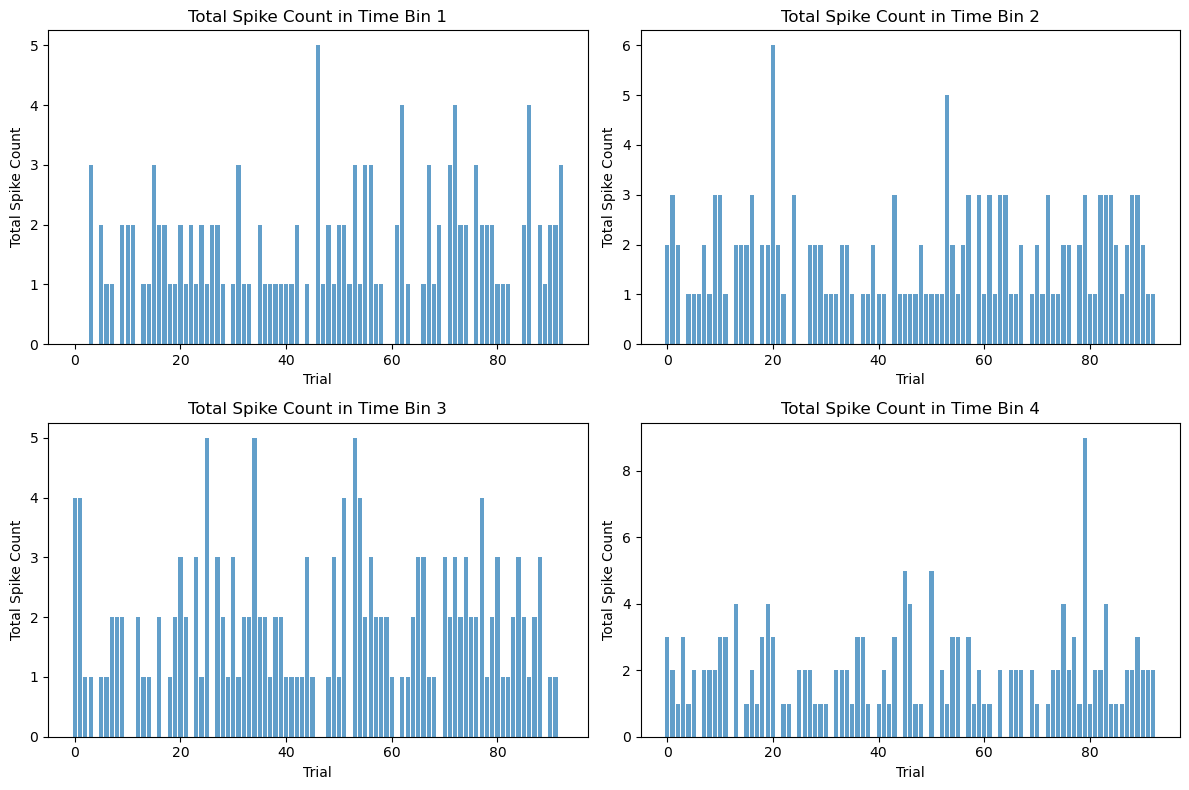

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the first dimension represents trials and the second dimension represents features
time_bin_data_transposed1 = time_bins[0]
time_bin_data_transposed2 = time_bins[1]
time_bin_data_transposed3 = time_bins[2]
time_bin_data_transposed4 = time_bins[3]

# Create a figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# List of data and corresponding labels
data_list = [time_bin_data_transposed1, time_bin_data_transposed2, time_bin_data_transposed3, time_bin_data_transposed4]
labels = ['Time Bin 1', 'Time Bin 2', 'Time Bin 3', 'Time Bin 4']

# Plot each time bin in a separate subplot
for i, (data, label) in enumerate(zip(data_list, labels)):
    ax = axes[i // 2, i % 2]  # Access the correct subplot
    total_spike_counts = np.sum(data, axis=0)
    ax.bar(range(len(total_spike_counts)), total_spike_counts, alpha=0.7)
    ax.set_title(f'Total Spike Count in {label}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Total Spike Count')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


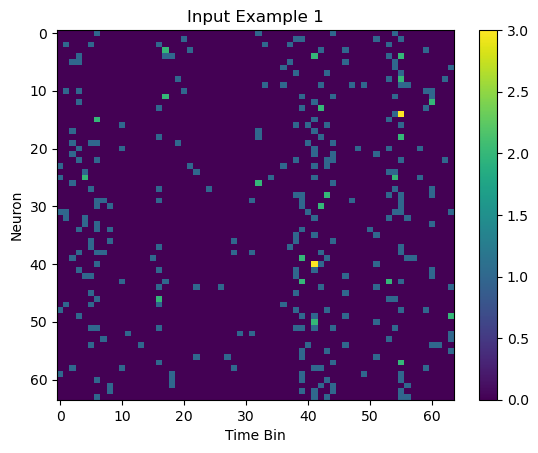

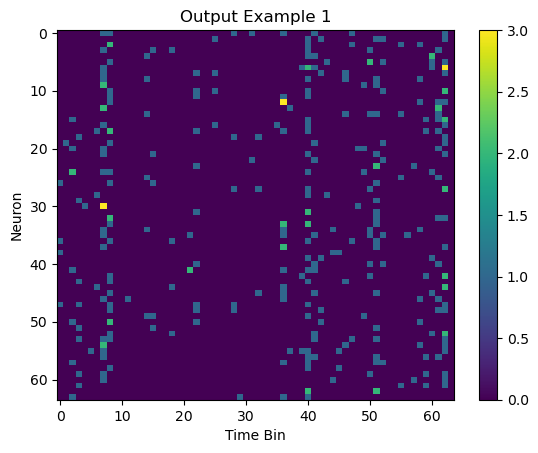

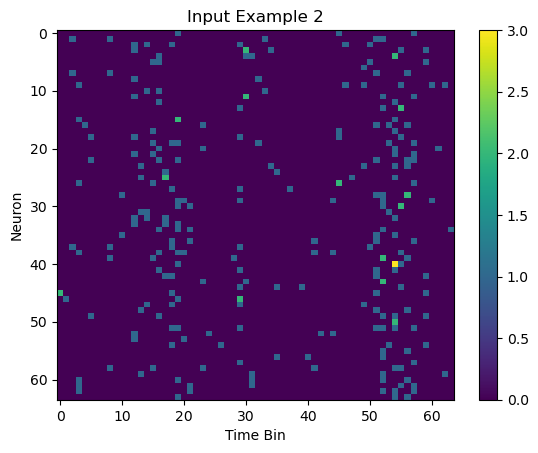

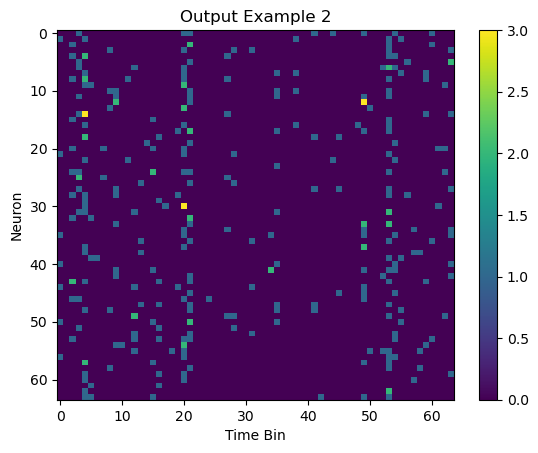

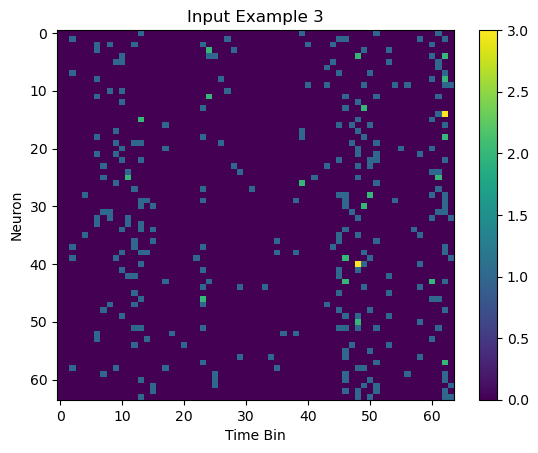

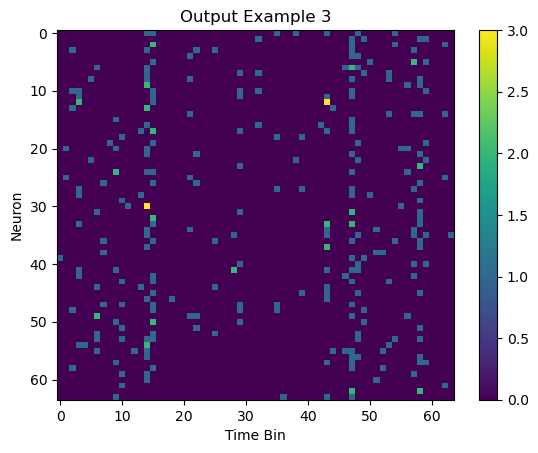

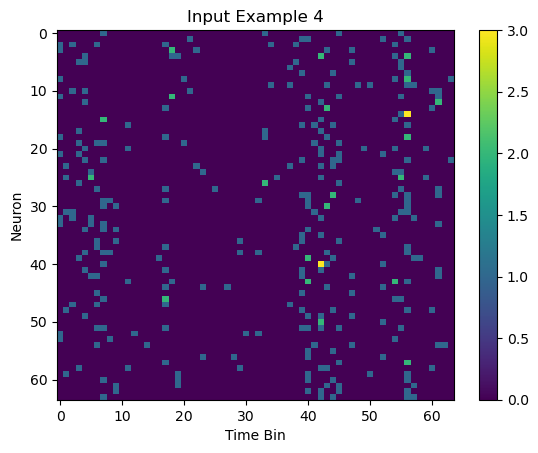

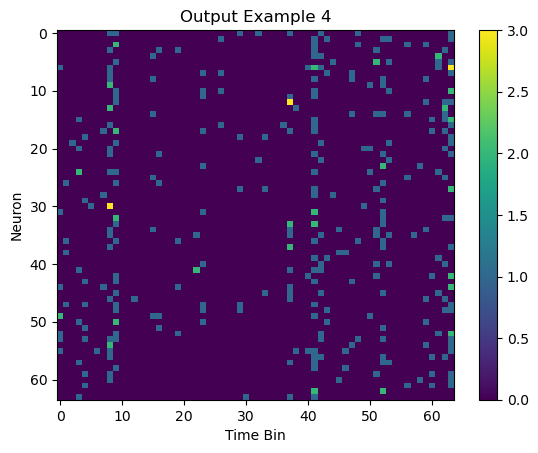

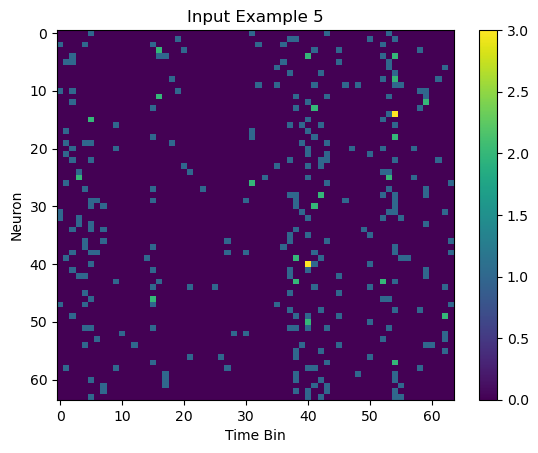

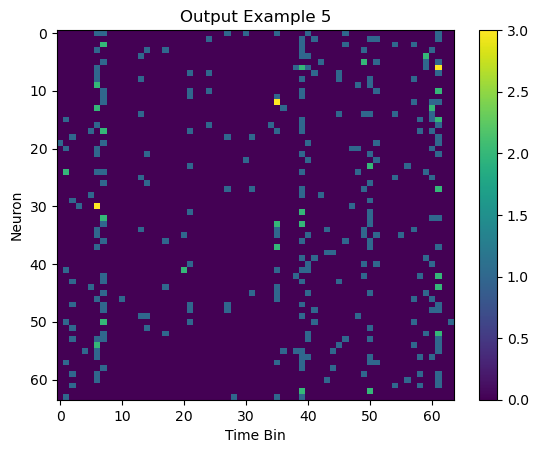

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# SpkCnt should be a 2D array with dimensions (num_time_bins, num_neurons)

# Sort neurons by activity
ord = np.argsort(-np.sum(SpkCnt, axis=0))

# Number of neurons and time bins
n_neur = 64
n_t = 64

# Number of training examples
num_examples = 100

# Create an array to store input and output images
training_data = []

for _ in range(num_examples):
    # Start window at random time
    t = np.random.randint(0, high=SpkCnt.shape[0] - 2 * n_t)

    # Select input and output images based on sorted neurons
    img_in = SpkCnt[t : t + n_t, ord[:n_neur]]
    img_out = SpkCnt[t + n_t : t + 2 * n_t, ord[:n_neur]]

    # Append to training data
    training_data.append((img_in, img_out))

# Plot a few examples
for i in range(min(5, num_examples)):
    plt.figure()
    plt.imshow(training_data[i][0].T, aspect='auto', cmap='viridis')
    plt.title(f'Input Example {i+1}')
    plt.xlabel('Time Bin')
    plt.ylabel('Neuron')
    plt.colorbar()

    plt.figure()
    plt.imshow(training_data[i][1].T, aspect='auto', cmap='viridis')
    plt.title(f'Output Example {i+1}')
    plt.xlabel('Time Bin')
    plt.ylabel('Neuron')
    plt.colorbar()

plt.show()


Image Array Shape: (64, 64), Dtype: float32
Modified Image Array Shape: (64, 64), Dtype: uint8
Image Array Shape: (64, 64), Dtype: float32
Modified Image Array Shape: (64, 64), Dtype: uint8
Image Array Shape: (64, 64), Dtype: float32
Modified Image Array Shape: (64, 64), Dtype: uint8
Image Array Shape: (64, 64), Dtype: float32
Modified Image Array Shape: (64, 64), Dtype: uint8
Image Array Shape: (64, 64), Dtype: float32
Modified Image Array Shape: (64, 64), Dtype: uint8


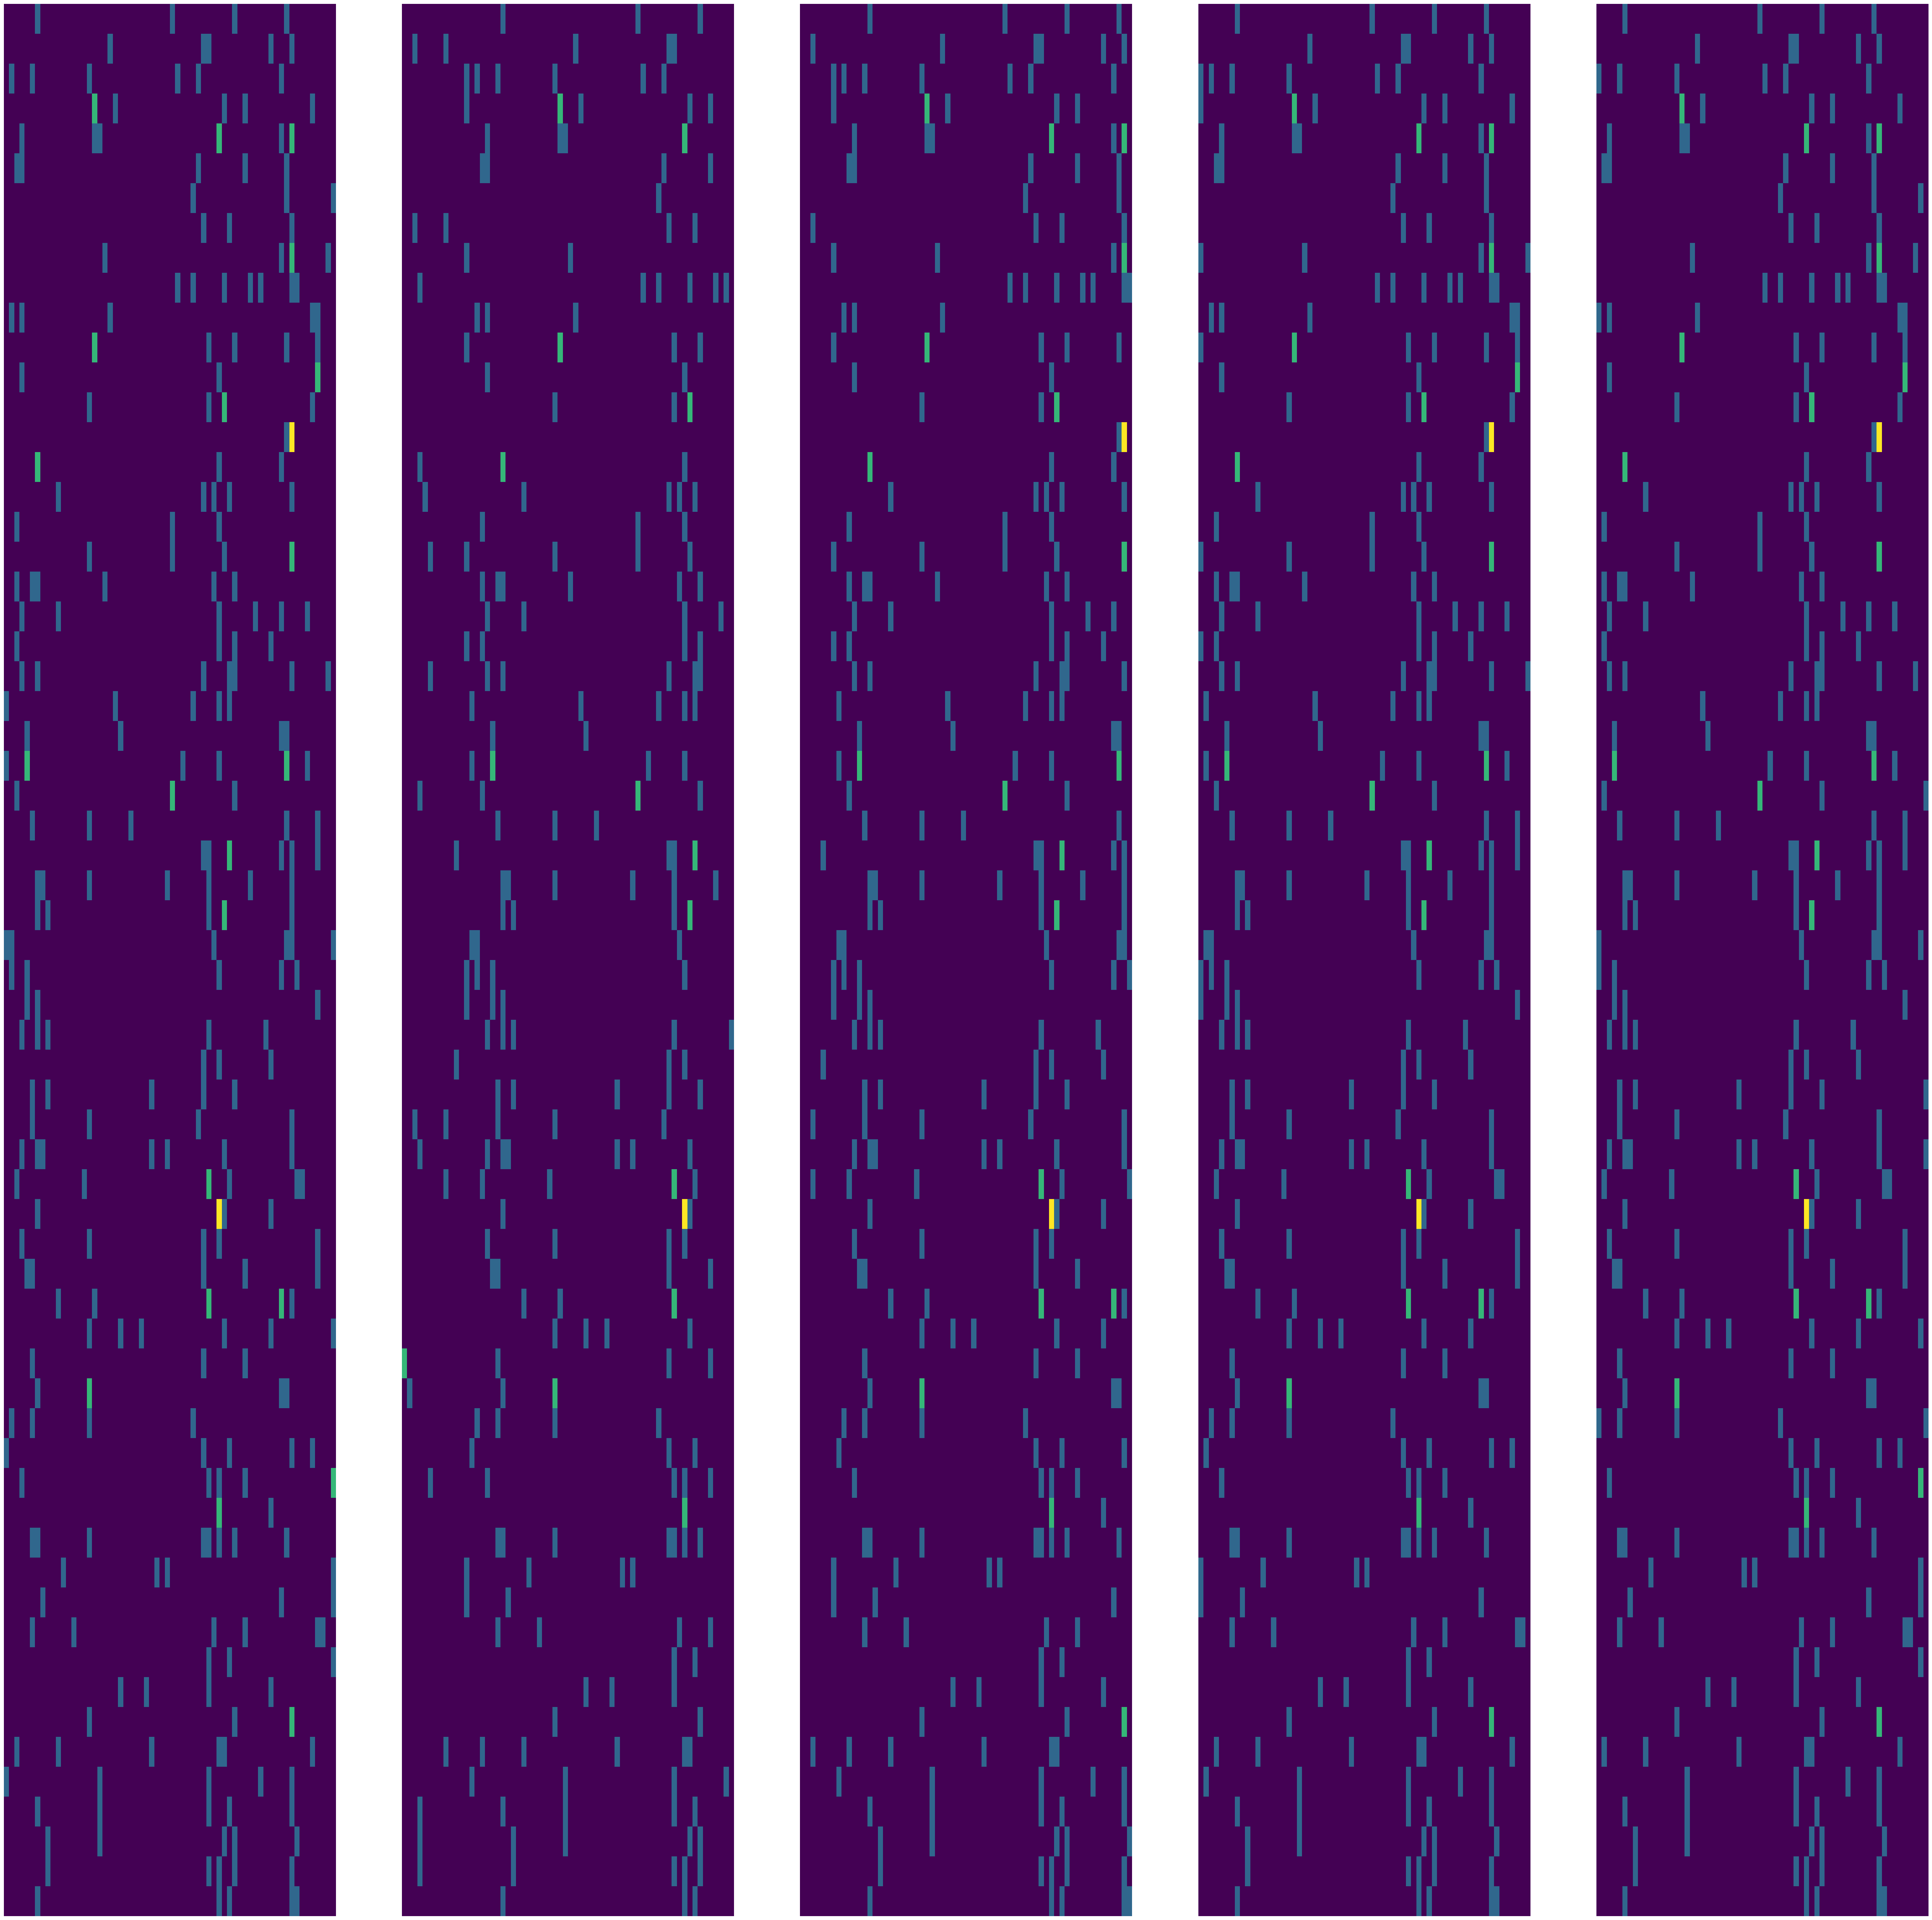

In [12]:
from PIL import Image

def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize=(64, 64))
    
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        print(f"Image Array Shape: {image_array.shape}, Dtype: {image_array.dtype}")
        
        # Assuming 'viridis' colormap and aspect='auto'
        axis.imshow(image_array, cmap='viridis', aspect='auto')  
        
        # Convert to uint8 for PIL compatibility
        image_array = (image_array * 255).astype(np.uint8)
        print(f"Modified Image Array Shape: {image_array.shape}, Dtype: {image_array.dtype}")
        
        # Convert to 'L' mode for single-channel image (grayscale)
        image = Image.fromarray(image_array, mode='L')
        image.save(name + "_" + str(epoch) + "_" + str(index) + ".png") 
    
    plt.savefig(name + "_" + str(epoch) + ".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

# Number of samples to show
num_samples_to_show = 5

# Generate samples using training data
sample_images = [training_data[i][0].T for i in range(num_samples_to_show)]

# Show the samples using the modified show_samples function
show_samples(sample_images, "sample", 1)


### Start training for whole dataset

In [13]:
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [283]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import TruncatedNormal

# Define a generator class using TensorFlow and Keras
class generator(tf.keras.Model):
    def __init__(self, output_channel_dim, **kwargs):
        super(generator, self).__init__(**kwargs)

        # Reshape layer to prepare the input for the transposed convolution
        self.reshape = tf.keras.layers.Reshape((64, 64, 1))

        # Transposed convolution layer 1
        self.trans_conv1 = Conv2DTranspose(filters=3,
                                           kernel_size=(5, 5),
                                           strides=(2, 2),
                                           padding="SAME",
                                           kernel_initializer=TruncatedNormal(stddev=0.02),
                                           name="trans_conv1")

        # Batch normalization for transposed convolution 1
        self.batch_trans_conv1 = BatchNormalization(epsilon=1e-5, name="batch_trans_conv1")

        # Leaky ReLU activation function
        self.leaky_relu = LeakyReLU()

    # Define the forward pass for the generator
    def call(self, z, training=False):
        # Reshape the input tensor
        reshaped_input = self.reshape(z)

        # Apply transposed convolution 1, batch normalization, and Leaky ReLU activation
        trans_conv1_out = self.leaky_relu(self.batch_trans_conv1(self.trans_conv1(reshaped_input), training=training))

        # Return the output of the generator
        return trans_conv1_out

# Example usage
# Create an instance of the generator with an output channel dimension of 3
Generator = generator(output_channel_dim=3)


In [334]:
# Constants for weight initialization and batch normalization epsilon
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 1e-5

# Define a discriminator class using TensorFlow and Keras
class discriminator(tf.keras.layers.Layer):
    def __init__(self, name='discriminator', **kwargs):
        super(discriminator, self).__init__(name=name, **kwargs)

        # Convolutional Layer 1
        self.conv1 = Conv2D(filters=64,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding="SAME",
                            kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                            name='conv1')

        # Batch Normalization for Convolutional Layer 1
        self.batch_norm1 = BatchNormalization(epsilon=EPSILON, name='batch_norm1')

        # Leaky ReLU activation for Convolutional Layer 1
        self.leaky_relu1 = LeakyReLU()

        # Convolutional Layer 2
        self.conv2 = Conv2D(filters=128,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding="SAME",
                            kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                            name='conv2')

        # Batch Normalization for Convolutional Layer 2
        self.batch_norm2 = BatchNormalization(epsilon=EPSILON, name='batch_norm2')

        # Leaky ReLU activation for Convolutional Layer 2
        self.leaky_relu2 = LeakyReLU()

        # Convolutional Layer 3
        self.conv3 = Conv2D(filters=64,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding="SAME",
                            kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                            name='conv3')

        # Batch Normalization for Convolutional Layer 3
        self.batch_norm3 = BatchNormalization(epsilon=EPSILON, name='batch_norm3')

        # Leaky ReLU activation for Convolutional Layer 3
        self.leaky_relu3 = LeakyReLU()

        # Flatten Layer to prepare for fully connected layers
        self.flatten = Flatten()

        # Dense (fully connected) layer for logits
        self.logits = Dense(units=1, activation=None)

    # Define the forward pass for the discriminator
    def call(self, x, training=False):
        # Apply convolutional layers with batch normalization and Leaky ReLU activation
        x = self.conv1(x)
        x = self.batch_norm1(x, training=training)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x, training=training)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x, training=training)
        x = self.leaky_relu3(x)

        # Flatten the output for the fully connected layers
        x = self.flatten(x)

        # Compute logits using a fully connected layer
        logits = self.logits(x)

        # Apply sigmoid activation to the logits for the final output
        output = tf.sigmoid(logits)

        # Return both the output and logits
        return output, logits

# Example usage
# Create an instance of the discriminator
Discriminator = discriminator()


In [335]:
# Model_input is used as a function to create input placeholders for the GAN model
def model_inputs(real_dim, z_dim):
    # Input placeholder for real data with shape 'real_dim'
    inputs_real = tf.keras.Input(shape=real_dim, name='inputs_real', dtype=tf.float32)
    
    # Input placeholder for random noise with shape 'z_dim'
    inputs_z = tf.keras.Input(shape=(z_dim,), name="input_z", dtype=tf.float32)
    
    # Input placeholder for the learning rate of the generator
    learning_rate_G = tf.keras.Input(shape=(), name="lr_g", dtype=tf.float32)
    
    # Input placeholder for the learning rate of the discriminator
    learning_rate_D = tf.keras.Input(shape=(), name="lr_d", dtype=tf.float32)
    
    # Return the created input placeholders
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D


In [336]:
from tensorflow.keras.losses import BinaryCrossentropy

# Define a function to calculate the loss for the GAN model
def model_loss(input_real, input_z, output_channel_dim):
    # Define a lambda function for the generator model
    g_model = lambda z: generator(z, output_channel_dim, training=True)

    # Add random noise to the real input data
    noisy_input_real = input_real + tf.random.normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=tf.random.uniform(shape=[], minval=0.0, maxval=0.1),
                                                     dtype=tf.float32)

    # Create instances of the discriminator for real and fake data
    d_model_real, d_logits_real = discriminator()(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator()(g_model(input_z), reuse=True)

    # Binary cross-entropy loss function
    bce_loss = BinaryCrossentropy()

    # Loss calculation without label smoothing
    # Discriminator loss for real and fake data
    d_loss_real = bce_loss(tf.ones_like(d_model_real), d_model_real)
    d_loss_fake = bce_loss(tf.zeros_like(d_model_fake), d_model_fake)
    
    # Total discriminator loss
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    # Generator loss
    g_loss = bce_loss(tf.ones_like(d_model_fake), d_model_fake)

    # Return both discriminator and generator losses
    return d_loss, g_loss


In [337]:
import tensorflow as tf

# Define a function to create and configure optimizers for the GAN model
def model_optimizer(d_loss, g_loss, LR_D, LR_G, BETA1):
    # Define a class to encapsulate the model and its optimizers
    class Model(tf.Module):
        def __init__(self, d_vars, g_vars):
            # Store discriminator and generator variables
            self.d_vars = d_vars
            self.g_vars = g_vars

            # Create Adam optimizers for discriminator and generator
            self.d_optimizer = tf.optimizers.Adam(learning_rate=LR_D, beta_1=BETA1)
            self.g_optimizer = tf.optimizers.Adam(learning_rate=LR_G, beta_1=BETA1)

        @tf.function
        def d_optimize(self, grads_and_vars):
            # Apply gradients to discriminator variables using the optimizer
            self.d_optimizer.apply_gradients(grads_and_vars, var_list=self.d_vars)

        @tf.function
        def g_optimize(self, grads_and_vars):
            # Apply gradients to generator variables using the optimizer
            self.g_optimizer.apply_gradients(grads_and_vars, var_list=self.g_vars)

    # Get all trainable variables
    t_vars = tf.compat.v1.trainable_variables()

    # Separate discriminator and generator variables
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

# This code is used to check the format of variables during run-time
#     # Print all trainable variables
#     print("All Trainable Variables:")
#     for var in t_vars:
#         print(var)

#     # Print discriminator and generator variables
#     print("Discriminator Variables:")
#     for var in d_vars:
#         print(var)

#     print("Generator Variables:")
#     for var in g_vars:
#         print(var)

    # Create an instance of the Model class with discriminator and generator variables
    model = Model(d_vars, g_vars)

    # Return the optimizer functions for discriminator and generator
    return model.d_optimize, model.g_optimize

In [338]:

# SpkCnt should be a 2D array with dimensions (num_time_bins, num_neurons)

# Sort neurons by activity
ord = np.argsort(-np.sum(SpkCnt, axis=0))

# Number of neurons and time bins
n_neur = 64
n_t = 64

# Number of training examples
num_examples = 100

# Create a folder to store images
output_folder = 'generated_images'
os.makedirs(output_folder, exist_ok=True)

# Create an array to store input and output images
training_data = []

for i in range(num_examples):
    # Start window at random time
    t = np.random.randint(0, high=SpkCnt.shape[0] - 2 * n_t)

    # Select input and output images based on sorted neurons
    img_in = SpkCnt[t : t + n_t, ord[:n_neur]]
    img_out = SpkCnt[t + n_t : t + 2 * n_t, ord[:n_neur]]

    # Append to training data
    training_data.append((img_in, img_out))

    # Save the images to the output folder
    input_image_path = os.path.join(output_folder, f'input_example_{i+1}.png')
    output_image_path = os.path.join(output_folder, f'output_example_{i+1}.png')

    plt.imsave(input_image_path, img_in.T, cmap='viridis')
    plt.imsave(output_image_path, img_out.T, cmap='viridis')

# Print the number of images generated
print(f"Number of images generated: {num_examples}")


Number of images generated: 100


In [339]:
from PIL import Image

def show_samples(sample_images, prefix, index):
    figure, axes = plt.subplots(1, len(sample_images), figsize=(64, 64))
    
    for i, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[i]
        print(f"Image Array Shape: {image_array.shape}, Dtype: {image_array.dtype}")
        
        # Assuming 'viridis' colormap and aspect='auto'
        axis.imshow(image_array, cmap='viridis', aspect='auto')  
        
        # Convert to uint8 for PIL compatibility
        image_array = (image_array * 255).astype(np.uint8)
        print(f"Modified Image Array Shape: {image_array.shape}, Dtype: {image_array.dtype}")
        
        # Convert to 'L' mode for single-channel image (grayscale)
        image = Image.fromarray(image_array, mode='L')
        
        # Save the image using the provided filename prefix and index
        image.save(f"{prefix}_{i+1}_{index}.png") 
    
    plt.savefig(f"{prefix}_{index}.png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [340]:
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    # Calculate the number of minibatches in the epoch
    minibatch_size = int(data_shape[0] // BATCH_SIZE)

    # Print summary information for the current epoch
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))

    # Create a plot for discriminator and generator losses
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()

    # Save the plot as an image file
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")

    # Display the plot
    plt.show()

    # Close the plot
    plt.close()

    # Call the test function to generate sample images and evaluate the generator
    test(sess, input_z, data_shape[3], epoch)


In [341]:
from PIL import Image

# Define a function to generate batches of augmented data
def get_batches(data):
    batches = []

    # Iterate over the data to create batches
    for i in range(int(data.shape[0] // BATCH_SIZE)):
        # Extract a batch of raw data
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        # List to store augmented images
        augmented_images = []

        # Apply data augmentation to each image in the batch
        for img in batch:
            # Convert the image to a PIL Image
            image = Image.fromarray(img)

            # Randomly decide whether to flip the image horizontally
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)

            # Append the augmented image to the list
            augmented_images.append(np.asarray(image))

        # Convert the list of augmented images to a NumPy array
        batch = np.asarray(augmented_images)

        # Normalize pixel values to the range [-1, 1]
        normalized_batch = (batch / 127.5) - 1.0

        # Append the normalized batch to the list of batches
        batches.append(normalized_batch)

    # Return the list of batches
    return batches


In [342]:
# Hyperparameters

# Size of the input images (assuming square images)
IMAGE_SIZE = 64

# Size of the noise vector input to the generator
NOISE_SIZE = 100

# Learning rate for the discriminator
LR_D = 0.00004

# Learning rate for the generator
LR_G = 0.0004

# Batch size for training
BATCH_SIZE = 64

# Number of training epochs
EPOCHS = 50  # For better results, increase this value

# Beta1 parameter for the Adam optimizer
BETA1 = 0.5

# Standard deviation for weight initialization
WEIGHT_INIT_STDDEV = 0.02

# Epsilon value for batch normalization
EPSILON = 0.00005

# Number of samples to show during training for visual inspection
SAMPLES_TO_SHOW = 5

#(d_loss, g_loss, LR_D, LR_G, BETA1)


In [343]:
import tensorflow as tf

# Define a function to compute losses without gradient computation
def compute_losses(input_images, input_z, d_model, g_model):
    # Define a function for loss computation using the given model
    @tf.function
    def compute_loss_fn(images, z, model):
        return model([images, z])

    # Compute discriminator and generator losses
    d_loss_value = compute_loss_fn(input_images, input_z, d_model)
    g_loss_value = compute_loss_fn(input_images, input_z, g_model)

    return d_loss_value, g_loss_value


# Define the training function
def train(dataset, data_shape, checkpoint_to_load=None):
    # Create input placeholders and define losses and optimizers
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizer(d_loss, g_loss, LR_D, LR_G, BETA1)

    # Start a TensorFlow session
    with tf.compat.v1.Session() as sess:
        # Initialize global variables
        sess.run(tf.compat.v1.global_variables_initializer())

        # Initialize epoch and iteration counters
        epoch = 0
        iteration = 0

        # Lists to store discriminator and generator losses
        d_losses = []
        g_losses = []

        # Iterate over epochs
        for epoch in range(EPOCHS):
            epoch += 1
            start_time = time.time()

            # Iterate over batches in the dataset
            for batch_images in dataset:
                iteration += 1

                # Generate random noise for the batch
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))

                # Compute losses without gradient computation
                d_loss_value, g_loss_value = compute_losses(batch_images, batch_z, d_loss, g_loss)

                # Update discriminator
                with tf.GradientTape() as tape:
                    _ = d_loss_value  # This is necessary to keep the tape persistent
                gradients = tape.gradient(d_loss_value, d_opt.variables)
                d_opt.apply_gradients(zip(gradients, d_opt.variables))

                # Update generator
                with tape:
                    _ = g_loss_value  # This is necessary to keep the tape persistent
                gradients = tape.gradient(g_loss_value, g_opt.variables)
                g_opt.apply_gradients(zip(gradients, g_opt.variables))

                # Append losses to the lists
                d_losses.append(d_loss_value)
                g_losses.append(g_loss_value)

            # Summarize the epoch by printing and plotting losses, and testing the model
            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)

In [ ]:
from PIL import Image

def show_samples(sample_images, prefix, index):
    for i, image_array in enumerate(sample_images):
        print(f"Image Array Shape: {image_array.shape}, Dtype: {image_array.dtype}")
        
        # Convert to 'RGBA' mode for images with an alpha channel
        image = Image.fromarray(image_array, mode='RGB')
        
        # Save the image using the provided filename prefix and index
        image.save(f"{prefix}_{i+1}_{index}.png")

In [26]:
working_directory = os.getcwd()
print(working_directory)

/Users/PC/Desktop/Independence


In [27]:

INPUT_DATA_DIR = r'/Users/PC/Desktop/Independence/generated_images/'

# Specify the output directory
OUTPUT_DIR = ''

# Display the paths
print("Input Data Directory:", INPUT_DATA_DIR)
print("Output Directory:", OUTPUT_DIR)

Input Data Directory: /Users/PC/Desktop/Independence/generated_images/
Output Directory: 


In [ ]:
# Training
print("Start!")

# Load and preprocess input images
input_images = np.asarray([np.asarray(Image.open(file).resize((64, 64)))[:,:,:3] for file in glob(INPUT_DATA_DIR + '*')])

# Keep only the first three channels for each image
# input_images = input_images[:, :, :, :3]
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

# sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
# show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

with tf.Graph().as_default():
    train(get_batches(input_images), input_images.shape)

### Seperate Line - Old codes

### SEPERATOR

In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class SpkCountDataset(Dataset):
    def __init__(self, spkcount_file, time_bin_size=0.3, transform=None):
        with h5py.File(spkcount_file, 'r') as spkcount_file_h5:
            spkcount_data = spkcount_file_h5['SpkCnt'][:]
        
        self.time_bin_size = int(312 * 60 * time_bin_size)  # Number of time bins in 0.3 seconds
        f = np.where(spkcount_data != 0)[0]

        # Create a list of dictionaries, each containing the relevant data
        self.data = [{"spkcount": spkcount_data[f_i - self.time_bin_size:f_i, :]} for f_i in f]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spkcount_data = self.data[idx]["spkcount"]

        # Downsample to every fifth time bin
        spkcount_data = spkcount_data[::5, :]

        if self.transform:
            spkcount_data = torch.tensor(spkcount_data, dtype=torch.float32)
            spkcount_data = self.transform({"SpkCnt": spkcount_data})
            spkcount_data = spkcount_data["SpkCnt"]

        return spkcount_data

def visualize_data(data_loader):
    for batch in data_loader:
        # Assuming each batch is a time bin, you can visualize it here
        for spkcount_data in batch:
            plt.imshow(spkcount_data.numpy(), aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.show()

spkcount_file_path = r'C:\Users\Default\Desktop\SpkCntData\SpkCnt_KA4_2014_05_07.mat'

# Create the custom dataset with time bin size of 0.3 seconds
spkcount_dataset = SpkCountDataset(spkcount_file=spkcount_file_path, time_bin_size=0.3)

# Specify other parameters for DataLoader
batch_size = 1  # Each batch is a time bin
shuffle = True
num_workers = 0  # Set num_workers to 0 for simplicity

# Create the DataLoader
spkcount_loader = DataLoader(spkcount_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Visualize the downsampled data (every fifth time bin)
visualize_data(spkcount_loader)


### Visualise examples from the training set

In [ ]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, RandAffined, Transform
from torchvision.transforms import Resize

class NormalizeSpkCnt(Transform):
    def __init__(self, keys):
        super().__init__()
        self.keys = keys

    def __call__(self, data):
        for key in self.keys:
            data[key] = (data[key] - data[key].min()) / (data[key].max() - data[key].min())
        return data


    custom_transforms = Compose([
    LoadImaged(keys=["SpkCnt"]),
    EnsureChannelFirstd(keys=["SpkCnt"]),
   # Resize((64, 64)),  # Resize to 64x64, do it later adter dividing time bins
    NormalizeSpkCnt(keys=["SpkCnt"]),
])

# Adjust the fraction of data to process
fraction_to_process = 1/10
total_samples = len(spkcount_loader.dataset)
num_samples_to_process = int(fraction_to_process * total_samples)

# Apply the transforms to a fraction of dataset
transformed_dataset = [custom_transforms(sample) for sample in spkcount_loader.dataset[:num_samples_to_process]]
print(transformed_dataset[0]["SpkCnt"].shape)


In [13]:
sample_idx = 50 
spkcount_sample = spkcount_dataset.data[sample_idx]["spkcount"]

spkcount_mean = np.mean(spkcount_sample)
spkcount_std = np.std(spkcount_sample)

print("Mean:", spkcount_mean)
print("Standard Deviation:", spkcount_std)

Mean: 0.0075147958
Standard Deviation: 0.08760603


### Calculate and extract reactive data

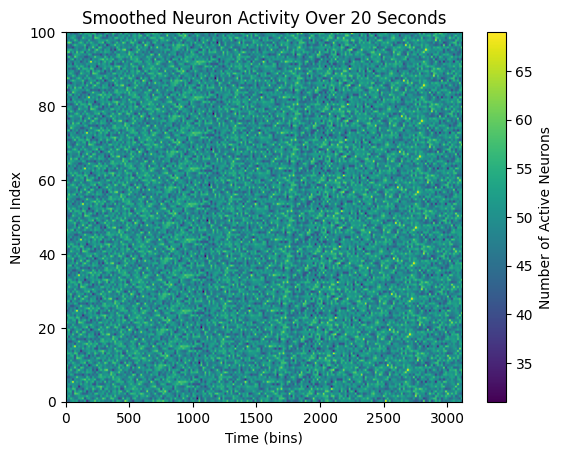

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming `spkcount_sample` contains SpkCnt data for a single sample
spkcount_sample = np.random.randint(0, 2, size=(10 * 312, 100))  # Example data for 20 seconds

# Define window size and stride
window_size = int(0.5 * 312)  # 0.5 seconds for longer patterns
stride = int(0.05 * 312)  # 0.05 seconds for more overlap

# Function to calculate the number of active neurons in each window
def count_active_neurons(data_window):
    return np.sum(data_window, axis=1)

# Iterate through the data using the sliding window
num_bins = spkcount_sample.shape[0]
neuron_activity = []

for start in range(0, num_bins - window_size + 1, stride):
    end = start + window_size
    window_data = spkcount_sample[start:end, :]
    active_neurons = count_active_neurons(window_data)
    neuron_activity.append(active_neurons)

# Convert the result to a numpy array for easier manipulation
neuron_activity = np.array(neuron_activity)

# Apply smoothing to the neuron activity data
neuron_activity_smoothed = gaussian_filter1d(neuron_activity.T, sigma=2).T

# Plotting the results
plt.imshow(neuron_activity.T, cmap='viridis', aspect='auto', extent=[0, num_bins, 0, 100])
plt.xlabel('Time (bins)')
plt.ylabel('Neuron Index')
plt.title('Smoothed Neuron Activity Over 20 Seconds')
plt.colorbar(label='Number of Active Neurons')
plt.show()


Count the number of neurons that have acitivity haigher than threshold (highly active, ex: 0.5)

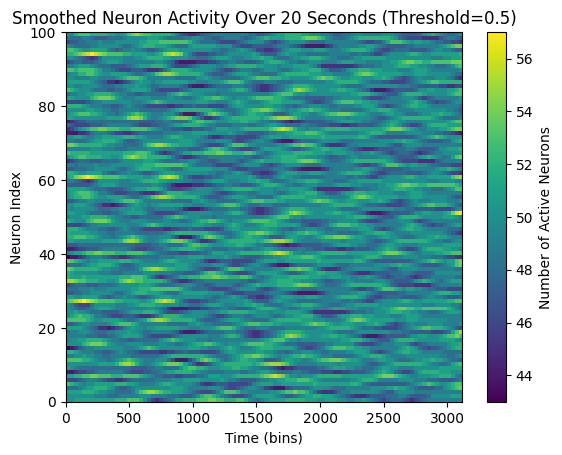

Mean Activity for Each Window: [49.79569892 50.02150538 50.12903226 50.59139785 50.40860215 50.66666667
 50.7311828  50.75268817 50.68817204 50.33333333 49.93548387 49.76344086
 49.07526882 49.44086022 49.66666667 51.10752688 50.93548387 50.82795699
 49.96774194 50.41935484 49.89247312 49.80645161 49.55913978 50.12903226
 51.20430108 51.05376344 50.32258065 49.65591398 49.48387097 49.51612903
 49.37634409 49.89247312 49.92473118 49.62365591 49.23655914 49.76344086
 49.74193548 49.51612903 49.50537634 49.8172043  50.06451613 50.29032258
 50.38709677 50.2688172  49.87096774 49.5483871  49.76344086 49.79569892
 50.17204301 50.09677419 50.1827957  49.97849462 50.41935484 50.44086022
 50.64516129 50.50537634 50.82795699 50.96774194 50.56989247 50.05376344
 50.23655914 50.41935484 50.22580645 49.32258065 49.16129032 49.74193548
 50.21505376 50.47311828 49.89247312 49.64516129 50.07526882 51.03225806
 50.88172043 50.58064516 49.52688172 49.39784946 48.83870968 49.01075269
 50.04301075 50.2365

In [22]:

# Define window size and stride
window_size = int(0.3 * 312)  # 0.3 seconds
stride = int(0.1 * 312)  # 0.1 seconds

# Threshold for counting active neurons
threshold = 0.5

# Function to calculate the number of neurons with activity higher than the threshold in each window
def count_active_neurons_above_threshold(data_window, threshold):
    return np.sum(data_window > threshold, axis=1)

# Iterate through the data using the sliding window
num_bins = spkcount_sample.shape[0]
neuron_activity = []

# Lists to store statistics for each window
mean_activity = []
std_activity = []
active_neurons_indices = []

for start in range(0, num_bins - window_size + 1, stride):
    end = start + window_size
    window_data = spkcount_sample[start:end, :]
    active_neurons = count_active_neurons_above_threshold(window_data, threshold)
    neuron_activity.append(active_neurons)

    # Calculate statistics for the current window
    mean_activity.append(np.mean(active_neurons))
    std_activity.append(np.std(active_neurons))
    active_neurons_indices.append(np.where(active_neurons > 0)[0])

# Convert the result to a numpy array for easier manipulation
neuron_activity = np.array(neuron_activity)

# Apply smoothing to the neuron activity data
neuron_activity_smoothed = gaussian_filter1d(neuron_activity.T, sigma=2).T

# Plotting the results
plt.imshow(neuron_activity_smoothed.T, cmap='viridis', aspect='auto', extent=[0, num_bins, 0, 100])
plt.xlabel('Time (bins)')
plt.ylabel('Neuron Index')
plt.title(f'Smoothed Neuron Activity Over 20 Seconds (Threshold={threshold})')
plt.colorbar(label='Number of Active Neurons')
plt.show()

# Print statistics
mean_activity = np.array(mean_activity)
std_activity = np.array(std_activity)
active_neurons_indices = np.array(active_neurons_indices)

print("Mean Activity for Each Window:", mean_activity)
print("Standard Deviation of Activity for Each Window:", std_activity)
print(f"Indices of Active Neurons (above {threshold}) for Each Window:", active_neurons_indices)


### Clean-up data directory

In [22]:
if directory is None:
    shutil.rmtree(root_dir)